In [27]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cesm import cesm_analyze as ca
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
vardict = {
    'huss': {'name': 'Specific Humidity', 'units': ''},
    'hurs': {'name': 'Relative Humidity', 'units': '[%]'},
    'pr': {'name': 'Precipitation', 'units': '$[\frac{kg}{m^{2}s}]$'},
    'tas': {'name': 'Air Temperature', 'units': 'K'},
    'tasmin': {'name': 'Daily Min. Air Temperature', 'units': 'K'},
    'tasmax': {'name': 'Daily Max. Air Temperature', 'units': 'K'},
}

modeldict = {
    'hist': {
        'code': 'historical', 'name': 'Historical Data'
    },
    'sp1': {
        'code': 'ssp126', 'name': r'$Scenario \#1: 2.6 \frac{W}{m^{2}}$'
    },
    'sp2': {
        'code': 'ssp245', 'name': r'$Scenario \#2: 4.5 \frac{W}{m^{2}}$'
    },
    'sp3': {
        'code': 'ssp370', 'name': r'$Scenario \#3: 7.0 \frac{W}{m^{2}}$'
    },
    'sp5': {
        'code': 'ssp585', 'name': r'$Scenario \#5: 8.5 \frac{W}{m^{2}}$'
    },
}

list(modeldict)

['hist', 'sp1', 'sp2', 'sp3', 'sp5']

In [6]:
ds = ca.dictorize(
    func = xr.open_zarr, 
    modeldict = {k: v['code'] for k, v in modeldict.items()},
)

print(f'Available datasets: {list(ds)}')
hist = ds['hist']

Available datasets: ['hist', 'sp1', 'sp2', 'sp3', 'sp5']


/home/jovyan/envs/cesm/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jovyan/envs/cesm/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


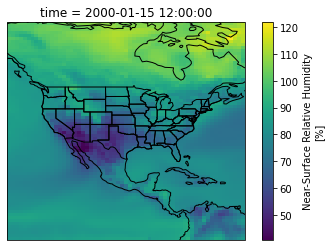

In [29]:
ds_ca = ca.dictorize(
    "sel", 
    ca.nest_dicts(
        ds,
        {'args': {'lat': slice(0, 70),
                 'lon': slice(225,300)}},
    )
)
crs = ccrs.PlateCarree()
ax = plt.subplot(projection=crs)
ds_ca["hist"].sel(time = "2000-01-15")["hurs"].plot(ax=ax, transform=crs)


  # set projection

# Plot on a map
ax.coastlines("110m", color="k")
#ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("110m"))


#{'args': {'lat': slice(25, 49.1),
 #                'lon': slice(54.9,100.2)}},

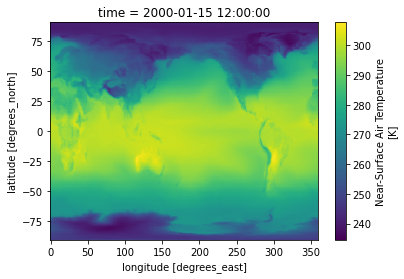

In [7]:
hist.sel(time = "2000-01-15")["tas"].plot()

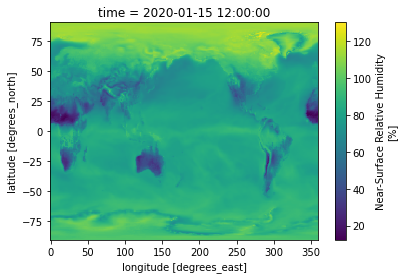

In [5]:
sp5.sel(time = "2020-01-15")["tas"].plot()

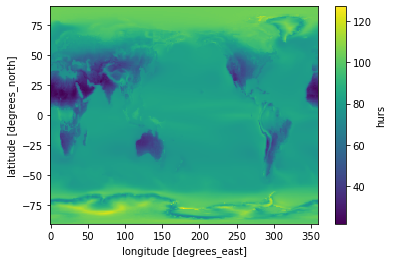

In [6]:
avg_hist = hist.mean("time").tas.plot()

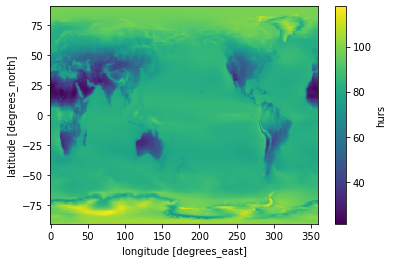

In [7]:
avg_sp5 = sp5.mean("time").hurs.plot()

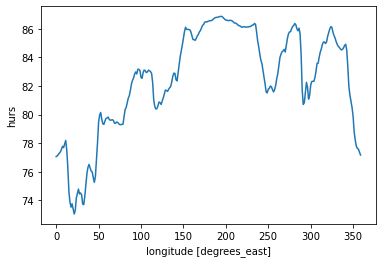

In [12]:
hist.mean(("lat", "time")).hurs.plot()

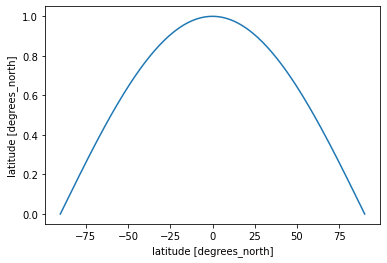

In [14]:
weights = np.cos(np.deg2rad(hist.lat))
weights.name = "weights"
weights.plot();

In [16]:
hist_weighted = hist.weighted(weights)
hist_weighted

DatasetWeighted with weights along dimensions: lat

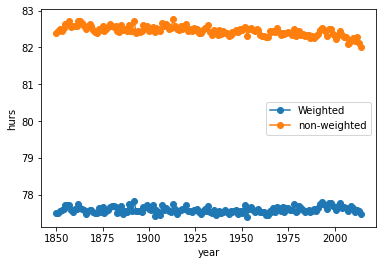

In [22]:
hist_weighted.mean(("lat", "lon")).groupby(hist.time.dt.year).mean().hurs.plot(marker='o', label="Weighted")
hist.groupby(hist.time.dt.year).mean().mean(("lat", "lon")).hurs.plot(marker='o', label="non-weighted")
plt.legend()

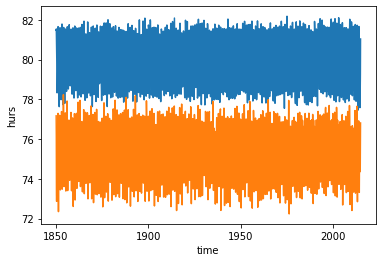

In [26]:
hist_south = hist.sel(lat=slice(-90,0))
hist_north = hist.sel(lat=slice(0,90))

weights_south = np.cos(np.deg2rad(hist_south.lat))
weights_north = np.cos(np.deg2rad(hist_north.lat))

hist_south_weigthed = hist_south.weighted(weights_south)
hist_north_weigthed = hist_north.weighted(weights_north)

t_hurs_south = hist_south_weigthed.mean(("lat", "lon")).hurs
t_hurs_south.plot();

t_hurs_north = hist_north_weigthed.mean(("lat", "lon")).hurs
t_hurs_north.plot();

In [28]:
def peaks(data):
    
    yy = data.time.dt.year
    min_y, max_y = yy.min().values.item(), yy.max().values.item()
    years = range(min_y, max_y + 1) 
    peaks = []
    
    for y in years:
        year = data.isel(time = data.time.dt.year == y)
        min_d, max_d = year.idxmin(), year.idxmax()
        min_v, max_v = year.sel(time = min_d), year.sel(time = max_d)
        min_day, max_day = min_d.dt.dayofyear, max_d.dt.dayofyear
        vals = [x.values.item() for x in [min_day, max_day, min_v, max_v, (max_v-min_v)]] 
        peaks.append([y, min_d.values, max_d.values] + vals)

    peaks = pd.DataFrame(peaks, 
                              columns = ['year', 'min_date', 'max_date',
                                         'min_dayofyear', 'max_dayofyear',
                                         'min_hurs', 'max_hurs', 'amplitude'])
    return peaks

peaks_north = peaks(t_hurs_north)